# seq2seq 모델

In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [22]:
import pandas as pd
from keras.utils import to_categorical, model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, LSTM, Dense
from keras.models import Model
import numpy as np

from IPython.display import SVG
from keras_preprocessing.sequence import pad_sequences

## 데이터 불러오기

In [23]:
df = pd.read_csv('./data/fra-eng/fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del df['lic']
print('전체 샘플의 개수 :',len(df))

전체 샘플의 개수 : 192341


In [24]:
df = df[0:60000] # 6만개만 저장
df.sample(10)

,src,tar
6682,Do you gamble?,Est-ce que vous jouez ?
41456,I don't get the joke.,Je n'ai pas compris la blague.
13093,Did he go there?,Est-il allé là ?
4883,I have a pen.,J’ai un stylo.
15542,There's no exit.,Il n'y a pas de sortie.
25418,That sounds right.,Ça semble coller.
33596,You've got a fever.,Vous avez de la fièvre.
10405,I like to talk.,J'aime discuter.
49371,I was quite surprised.,J'étais très surpris.
47677,He has too many books.,Il a trop de livres.


In [25]:
df.head(10)

,src,tar
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.
5,Run!,Cours !
6,Run!,Courez !
7,Run!,Prenez vos jambes à vos cous !
8,Run!,File !
9,Run!,Filez !


In [26]:
df.tail()

,src,tar
59995,Why would they do that?,Pourquoi feraient-elles ça ?
59996,Why would you ask that?,Pourquoi demanderais-tu cela ?
59997,Why would you ask that?,Pourquoi demanderiez-vous cela ?
59998,Why would you say that?,Pourquoi dirais-tu cela ?
59999,Why would you say that?,Pourquoi diriez-vous cela ?


## 데이터 전처리

In [27]:
'''
시작을 의미하는 심볼 '\t'
종료를 의미하는 심볼 '\n'
'''
df.tar = df.tar.apply(lambda x : '\t '+ x + ' \n')
df.sample(10)

,src,tar
13251,Drink something.,\t Bois quelque chose. \n
35456,I like it very much.,\t J'aime ça à l'os. \n
41201,Huskies are friendly.,\t Les huskies sont sympathiques. \n
12204,We all do that.,\t Nous le faisons tous. \n
52927,Why do we have dreams?,\t Pourquoi rêvons-nous ? \n
28448,He asked for money.,\t Il a quémandé de l'argent. \n
3171,I need more.,\t Il m'en faut plus. \n
3519,It's a fake.,\t C'est une contrefaçon. \n
23527,I have no savings.,\t Je ne dispose pas d'économies. \n
17200,Can you hurry up?,\t Peux-tu te dépêcher ? \n


In [28]:
# 문자 집합 구축
src_vocab = set()
for line in df.src: # 1줄씩 읽음
    for char in line: # 1개의 문자씩 읽음
        src_vocab.add(char)

tar_vocab = set()
for line in df.tar:
    for char in line:
        tar_vocab.add(char)

In [29]:
src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)
print('source 문장의 char 집합 :',src_vocab_size)
print('target 문장의 char 집합 :',tar_vocab_size)

source 문장의 char 집합 : 79
target 문장의 char 집합 : 104


In [30]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab)
print(tar_vocab[45:75])

[' ', '!', '"', '$', '%', '&', "'", ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '°', 'é', '’', '€']
['T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']


In [31]:
# 각 문자에 인덱스 부여
src_to_index = dict([(char, i+1) for i, char in enumerate(src_vocab)])
tar_to_index = dict([(char, i+1) for i, char in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, '°': 76, 'é': 77, '’': 78, '€': 79}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 3

### 데이터 정수 인코딩

In [32]:
encoder_input = []

# 1개의 문장
for line in df.src:
  encoded_line = []
  # 각 줄에서 1개의 char
  for char in line:
    # 각 char을 정수로 변환
    encoded_line.append(src_to_index[char])
  encoder_input.append(encoded_line)

print('source 문장의 정수 인코딩 :',encoder_input[:5])

source 문장의 정수 인코딩 : [[30, 64, 10], [30, 64, 10], [30, 64, 10], [31, 58, 10], [31, 58, 10]]


In [33]:
decoder_input = []

for line in df.tar:
  decoded_line = []
  for char in line:
    decoded_line.append(tar_to_index[char])
  decoder_input.append(decoded_line)

print('target 문장의 정수 인코딩 :',decoder_input[:5])

target 문장의 정수 인코딩 : [[1, 3, 48, 53, 3, 4, 3, 2], [1, 3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [1, 3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 14, 3, 2]]


In [34]:
'''
디코더의 예측값과 비교하기 위한 실제값은
시작 심볼에 해당되는 <sos>가 있을 필요가 없다.

따라서 정수 인코딩 과정에서 <sos>를 제거한다.
'''
decoder_target = []

for line in df.tar:
  timestep = 0
  decoded_line = []
  for char in line:
    if timestep > 0:
      decoded_line.append(tar_to_index[char])
    timestep = timestep + 1
  decoder_target.append(decoded_line)

print('target 문장 레이블의 정수 인코딩 :',decoder_target[:5])

target 문장 레이블의 정수 인코딩 : [[3, 48, 53, 3, 4, 3, 2], [3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 14, 3, 2]]


### 데이터 패딩 처리

In [35]:
max_src_len = max([len(line) for line in df.src])
max_tar_len = max([len(line) for line in df.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 23
target 문장의 최대 길이 : 76


In [36]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

### 데이터 원 핫 인코딩

In [37]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

In [38]:
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(60000, 23, 80)
(60000, 76, 105)
(60000, 76, 105)


## 모델 생성

In [39]:
encoder_inputs = Input(shape=(None, src_vocab_size+1))
encoder_lstm = LSTM(units=256, return_state=True)

# encoder_outputs은 여기서는 불필요
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 은닉 상태와 셀 상태.
encoder_states = [state_h, state_c]

In [40]:
decoder_inputs = Input(shape=(None, tar_vocab_size+1))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# 디코더에게 인코더의 은닉 상태, 셀 상태를 전달.
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_softmax_layer = Dense(tar_vocab_size+1, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 80)]   0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        345088      ['input_3[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

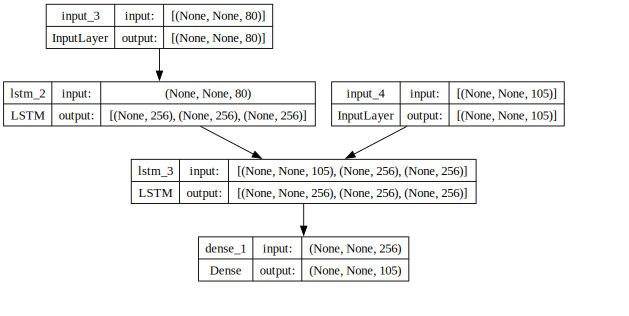

In [42]:
# %matplotlib inline

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [43]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy",metrics=['acc'])

In [44]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=40, validation_split=0.2)

Epoch 1/40
750/750 [==============================] - 35s 42ms/step - loss: 0.7673 - acc: 0.7933 - val_loss: 0.6744 - val_acc: 0.8007
Epoch 2/40
750/750 [==============================] - 30s 40ms/step - loss: 0.4731 - acc: 0.8587 - val_loss: 0.5492 - val_acc: 0.8352
Epoch 3/40
750/750 [==============================] - 30s 41ms/step - loss: 0.3959 - acc: 0.8809 - val_loss: 0.4820 - val_acc: 0.8558
Epoch 4/40
750/750 [==============================] - 31s 41ms/step - loss: 0.3524 - acc: 0.8933 - val_loss: 0.4460 - val_acc: 0.8652
Epoch 5/40
750/750 [==============================] - 31s 41ms/step - loss: 0.3236 - acc: 0.9017 - val_loss: 0.4225 - val_acc: 0.8720
Epoch 6/40
750/750 [==============================] - 31s 41ms/step - loss: 0.3031 - acc: 0.9077 - val_loss: 0.4067 - val_acc: 0.8773
Epoch 7/40
750/750 [==============================] - 31s 41ms/step - loss: 0.2874 - acc: 0.9123 - val_loss: 0.3949 - val_acc: 0.8806
Epoch 8/40
750/750 [==============================] - 31s 42ms

## 모델 테스트

In [45]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [46]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 뒤의 함수 decode_sequence()에 동작을 구현 예정
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태를 버리지 않음.
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [47]:
'''
단어로부터 인덱스를 얻는 것이 아닌
인덱스로부터 단어를 얻을 수 있는 index_to_src와 index_to_tar
'''
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

In [58]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 원-핫 벡터 생성
  target_seq = np.zeros((1, 1, tar_vocab_size+1))
  target_seq[0, 0, tar_to_index['\t']] = 1.

  stop_condition = False
  decoded_sentence = ""

  # stop_condition이 True가 될 때까지 루프 반복
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

    # 예측 결과를 문자로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 문자를 예측 문장에 추가
    decoded_sentence += sampled_char

    # <eos>에 도달하거나 최대 길이를 넘으면 중단.
    if (sampled_char == '\n' or
        len(decoded_sentence) > max_tar_len):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1, 1, tar_vocab_size+1))
    target_seq[0, 0, sampled_token_index] = 1.

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [60]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
  input_seq = encoder_input[seq_index:seq_index+1]
  decoded_sentence = decode_sequence(input_seq)

  print('입력 문장:', df.src[seq_index])
  print('정답 문장:', df.tar[seq_index][2:len(df.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
  print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력

1/1 [==============================] - 0s 16ms/step
입력 문장: Hi.
정답 문장: Salut ! 
번역 문장: Salut. 
1/1 [==============================] - 0s 8ms/step
입력 문장: I see.
정답 문장: Aha. 
번역 문장: Je vois une bière. 
1/1 [==============================] - 0s 8ms/step
입력 문장: Hug me.
정답 문장: Serrez-moi dans vos bras ! 
번역 문장: Serrez-moi ! 
1/1 [==============================] - 0s 8ms/step
입력 문장: Help me.
정답 문장: Aidez-moi. 
번역 문장: Aidez-moi. 
1/1 [==============================] - 0s 8ms/step
입력 문장: I am sure.
정답 문장: Je suis sûr. 
번역 문장: Je suis patient. 
